## Возможность А/Б-тестирования для рекомендательной системы

### Цель проекта

Добавить в существующий сервис (2-й этап) возможность проведения А/Б-тестирования

### Задачи

1. Обучить вторую модель, используя для обработки текстов постов энкодер от трансформера при помощи библиотеки PyTorch. Данную модель принять за тестовую, модель из 2-го этапа — за контрольную;
2. Добавить разделение пользователей на 2 группы при помощи хэширования.
3. Добавить в сервис возможность применять одну из двух моделей для рекомендаций в зависимости от группы пользователя, логировать, какая модель применялась
4. В ответе endpoint-а указать группу, в которую попал пользователь ("control" или "test")

### Описание данных

Таблица `user_data`

Cодержит информацию о всех пользователях соц.сети

- `age`	- Возраст пользователя
- `city`	- Город пользователя
- `country` -	Страна пользователя
- `exp_group` -	Экспериментальная группа: некоторая зашифрованная категория
- `gender`	- Пол пользователя
- `id`	- Уникальный идентификатор пользователя
- `os`	- Операционная система устройства, с которого происходит пользование соц.сетью
- `source`	- Пришел ли пользователь в приложение с органического трафика или с рекламы

Таблица `post_text_df`

Содержит информацию о постах и уникальный ID каждой единицы с соответствующим ей текстом и топиком

- `id`	- Уникальный идентификатор поста
- `text` - Текстовое содержание поста
- `topic` - Основная тематика

Таблица `feed_data`

Содержит историю о просмотренных постах для каждого юзера

- `timestamp` - Время, когда был произведен просмотр
- `user_id` - id пользователя, который совершил просмотр
- `post_id`	- id просмотренного поста
- `action`	- Тип действия: просмотр или лайк
- `target`	- 1 у просмотров, если почти сразу после просмотра был совершен лайк, иначе 0. У действий like пропущенное значение

## Параметры и подключаемые библиотеки

In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from dotenv import load_dotenv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm import tqdm
from transformers import AutoTokenizer
from transformers import DistilBertModel
from category_encoders import TargetEncoder
from sklearn.decomposition import PCA 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sqlalchemy import create_engine


## Подключение к базе и основные таблицы
### users

In [59]:
# Создадим подключение к базе данных

load_dotenv()
conn_url = os.environ.get("POSTGRES_URL")

In [60]:
# Посмотрим на данные о пользователях

user_data = pd.read_sql(
    "SELECT * FROM public.user_data",
    conn_url
)
user_data

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [61]:
### Запросим количество просмотров по топикам для каждого юзера

user_view_by_topic = pd.read_sql(    
    """
    SELECT public.feed_data.user_id, public.post_text_df.topic, COUNT(public.feed_data.action)
    FROM public.feed_data
    JOIN public.post_text_df ON public.feed_data.post_id=public.post_text_df.post_id
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.user_id, public.post_text_df.topic;
    """,
    conn_url
)
user_view_by_topic.head()

,user_id,topic,count
0,200,business,28
1,200,covid,93
2,200,entertainment,14
3,200,movie,88
4,200,politics,58


In [62]:
### Развернем таблицу колонками по топикам

user_view_by_topic = user_view_by_topic.pivot_table(index="user_id",
                                                   columns="topic",
                                                   values="count")

user_view_by_topic.head(3)

topic,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,
200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [63]:
# Уберем topic и user_id из названия колонок

user_view_by_topic.columns.name = None
user_view_by_topic.reset_index(inplace=True)
user_view_by_topic.head(3)

,user_id,business,covid,entertainment,movie,politics,sport,tech
0,200,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [64]:
# Заполним пустые значения нулями и проверим на пустые значения

user_view_by_topic.fillna(0, inplace=True)
user_view_by_topic.isna().sum()

user_id          0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

In [65]:
### Добавим ко всем пользователям колонки с просмотрами по топикам

user_data = pd.merge(user_data, user_view_by_topic, on="user_id", how="left")
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [66]:
### Сгенерируем доп фичи через кластеризацию юзеров

user_df = user_data.copy()
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,11.0,137.0,25.0,49.0,9.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,5.0,64.0,10.0,17.0,3.0


In [67]:
### Преобразуем exp_forup в категориальный признак

user_df.exp_group = user_df.exp_group.astype("object")
user_df.set_index("user_id", inplace=True)
user_df.head(3)

,gender,age,country,city,exp_group,os,source,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,,,,,,,,
200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,14.0,88.0,58.0,64.0,13.0
201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,33.0,269.0,72.0,86.0,29.0
202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,27.0,276.0,59.0,77.0,21.0


In [68]:
### Применим трансформер для преобразования фичей

user_obj_cols = list(user_df.select_dtypes(include='object').columns)
user_num_cols = list(user_df.select_dtypes(exclude='object').columns)

### Сохраним индексы этих колонок

user_obj_cols_idx = [list(user_df.columns).index(col) for col in user_obj_cols]
user_num_cols_idx = [list(user_df.columns).index(col) for col in user_num_cols]

t_users=[
    ('ohe', OneHotEncoder(handle_unknown="ignore", drop="first"), user_obj_cols_idx),
    ('std', StandardScaler(), user_num_cols_idx)
]

In [69]:
#%%script false --no-raise-error

# Подберем оптимальное числло кластеров

distortion = []
K = range(1, 20) 

for k in K:
    user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),
                          
                          ("kmeans", KMeans(n_clusters=k, random_state=0))])
    
    user_pipe.fit(user_df)
    distortion.append(user_pipe[1].inertia_)

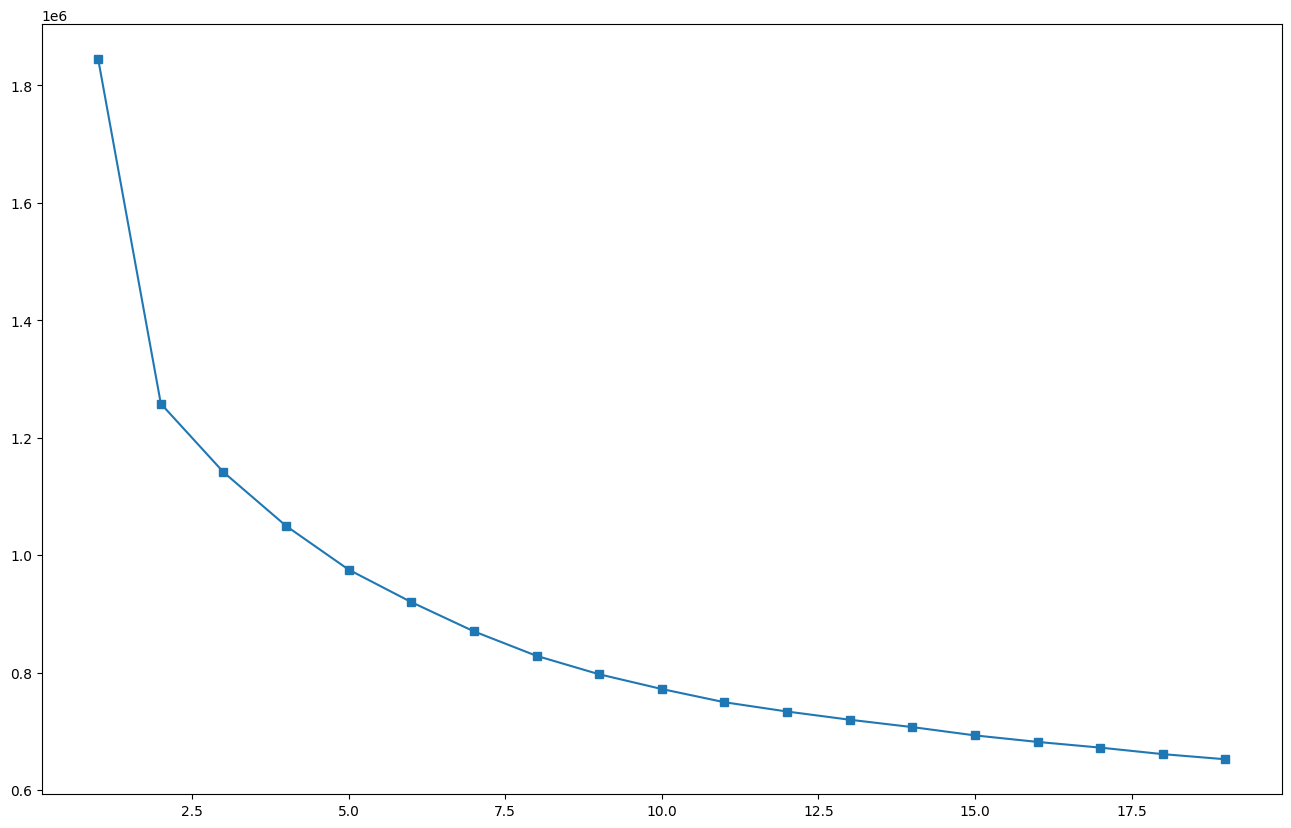

In [70]:
#%%script false --no-raise-error

fig = plt.figure()
fig.set_size_inches(16, 10)
plt.plot(K, distortion, "s-")
plt.xticks
plt.show()

In [71]:
### Разделим юзеров по 8 кластерам и вычислим межкластерное расстояние, которое используем как фичи

user_pipe = Pipeline([("transform", ColumnTransformer(t_users)),
                      
                      ("kmeans", KMeans(n_clusters=8, random_state=0))])

user_pipe.fit(user_df)

user_kmeans = user_pipe.transform(user_df)

### В качестве дополнительных признаков будем использовать расстояния до центров кластеров

user_kmeans_cols = [f"user_dist_to_{i + 1}_cluster" for i in range(user_kmeans.shape[1])]

user_kmeans = pd.DataFrame(user_kmeans, columns=user_kmeans_cols)
user_kmeans['user_num_cluster'] = user_pipe[1].labels_

user_kmeans.head(3)


,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [72]:
### Присоединим кластеры

user_data = pd.concat((user_data, user_kmeans), axis=1)

# переведем exp_group в категориальный признак
user_df.exp_group = user_df.exp_group.astype("object")


In [73]:
### Итоговая таблица по юзерам
user_data.head(3)

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6


In [74]:
user_data.isna().any().sum()

0

### posts

In [75]:
### Данные о постах

post_text_df = pd.read_sql(
    "SELECT * FROM public.post_text_df",
    conn_url
)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [76]:
# Загрузим предобученный токиныйзер и модель DistilBert
 
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')

In [77]:
# Переведем модель на GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)

cuda:0
NVIDIA GeForce RTX 3060 Laptop GPU


In [78]:
# Сделаем датасет для постов и лоадер

class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])
    
    
dataset = PostDataset(post_text_df['text'].values.tolist(), tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loader = DataLoader(dataset, batch_size=32, collate_fn=data_collator, pin_memory=True, shuffle=False)

In [79]:
# Функция для векторизации текстов постов

@torch.inference_mode()
def get_embeddings_labels(model, loader):
    model.eval()
    
    total_embeddings = []
    
    for batch in tqdm(loader):
        batch = {key: batch[key].to(device) for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, 0, :]

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)

In [80]:
embeddings = get_embeddings_labels(model, loader).numpy()
embeddings

100%|██████████| 220/220 [01:30<00:00,  2.44it/s]


array([[ 3.6315086e-01,  4.8937496e-02, -2.6408118e-01, ...,
        -1.4159346e-01,  1.5918216e-02,  9.1982896e-05],
       [ 2.3641640e-01, -1.5950108e-01, -3.2779828e-01, ...,
        -2.8993604e-01,  1.1936528e-01, -1.6235473e-03],
       [ 3.7519148e-01, -1.1394388e-01, -2.4054705e-01, ...,
        -3.3891949e-01,  5.8694065e-02, -2.1265799e-02],
       ...,
       [ 3.4038264e-01,  6.6492371e-02, -1.6318466e-01, ...,
        -8.6562671e-02,  2.0340401e-01,  3.2090727e-02],
       [ 4.3209207e-01,  1.1091524e-02, -1.1730625e-01, ...,
         7.5401627e-02,  1.0273982e-01,  1.5274254e-02],
       [ 3.0427775e-01, -7.6215617e-02, -6.7758717e-02, ...,
        -5.4348834e-02,  2.4438351e-01, -1.4148550e-02]], dtype=float32)

In [81]:
# Проверим размерность получившихся векторов

embeddings.shape

(7023, 768)

In [82]:
# Уменьшим размерность векторов

centered = embeddings - embeddings.mean()

pca = PCA(n_components=50)
posts_decomp = pca.fit_transform(centered)
posts_decomp.shape

(7023, 50)

In [83]:
# Разделим посты на 16 кластеров и вычислим межкластерное расстояние, которое используем как фичи

kmeans_posts = KMeans(n_clusters=16, random_state=0).fit(posts_decomp)

post_kmeans = kmeans_posts.transform(posts_decomp)

post_kmeans_cols = [f"post_dist_to_{i + 1}_cluster" for i in range(post_kmeans.shape[1])]

post_kmeans = pd.DataFrame(post_kmeans, columns=post_kmeans_cols)
post_kmeans['post_num_cluster'] = kmeans_posts.labels_
post_kmeans.head(3)

,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,3.752098,3.624116,2.223007,3.384465,3.438756,3.371514,2.334057,1.855183,2.831588,3.004876,3.407511,1.920812,3.431117,3.441214,3.470393,3.478053,7
1,3.552263,3.358622,2.238044,3.383924,3.312161,3.322973,2.303460,1.431602,2.546385,2.849822,3.210823,2.215849,3.323113,2.974838,3.244523,3.118210,7
2,3.558530,3.363245,3.039129,3.500733,3.404338,3.266564,2.382445,1.681438,2.881291,3.037199,3.257700,1.848103,3.335244,2.964562,3.392670,3.102985,7


In [84]:
# Присоединим межкластерные расстояния к постам

post_text_df = pd.concat((post_text_df, post_kmeans), axis=1)

post_text_df.head(5)

,post_id,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,post_dist_to_8_cluster,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,3.752098,3.624116,2.223007,3.384465,3.438756,3.371514,2.334057,1.855183,2.831588,3.004876,3.407511,1.920812,3.431117,3.441214,3.470393,3.478053,7
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,3.552263,3.358622,2.238044,3.383924,3.312161,3.322973,2.303460,1.431602,2.546385,2.849822,3.210823,2.215849,3.323113,2.974838,3.244523,3.118210,7
2,3,Asian quake hits European shares\n\nShares in ...,business,3.558530,3.363245,3.039129,3.500733,3.404338,3.266564,2.382445,1.681438,2.881291,3.037199,3.257700,1.848103,3.335244,2.964562,3.392670,3.102985,7
3,4,India power shares jump on debut\n\nShares in ...,business,2.999648,3.789803,3.393257,3.709813,3.798617,3.507532,2.799439,2.425590,3.370704,3.278013,3.661708,2.462021,3.740293,3.708647,4.059350,3.799567,7
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3.326157,3.052249,2.936760,2.805150,2.804073,3.034856,2.026418,2.119202,2.145612,2.645128,2.853799,1.443234,2.829998,2.638069,3.239344,2.810886,11


In [85]:
# Добавим количество лайков по постам

post_view_count = pd.read_sql(
    """
    SELECT public.feed_data.post_id, COUNT(public.feed_data.action) AS view_sum 
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    GROUP BY public.feed_data.post_id;
    """,
    conn_url
)

post_text_df = pd.merge(post_text_df, post_view_count,
                        on="post_id", how="left")
post_text_df.head(3)

,post_id,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,3.752098,3.624116,2.223007,3.384465,3.438756,3.371514,2.334057,...,2.831588,3.004876,3.407511,1.920812,3.431117,3.441214,3.470393,3.478053,7,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,3.552263,3.358622,2.238044,3.383924,3.312161,3.322973,2.303460,...,2.546385,2.849822,3.210823,2.215849,3.323113,2.974838,3.244523,3.118210,7,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,3.558530,3.363245,3.039129,3.500733,3.404338,3.266564,2.382445,...,2.881291,3.037199,3.257700,1.848103,3.335244,2.964562,3.392670,3.102985,7,8412.0


In [86]:
# Проверим на отсутсвующие значения

post_text_df.view_sum.isna().sum()

192

In [87]:
### Заполним отсутсвующие значения

post_text_df.fillna(0, inplace=True)
post_text_df.head(3)

,post_id,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,3.752098,3.624116,2.223007,3.384465,3.438756,3.371514,2.334057,...,2.831588,3.004876,3.407511,1.920812,3.431117,3.441214,3.470393,3.478053,7,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,3.552263,3.358622,2.238044,3.383924,3.312161,3.322973,2.303460,...,2.546385,2.849822,3.210823,2.215849,3.323113,2.974838,3.244523,3.118210,7,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,3.558530,3.363245,3.039129,3.500733,3.404338,3.266564,2.382445,...,2.881291,3.037199,3.257700,1.848103,3.335244,2.964562,3.392670,3.102985,7,8412.0


In [88]:
post_text_df.isna().sum().any()

False

In [89]:
### Почистим переменные
%who

AutoTokenizer	 CatBoostClassifier	 ColumnTransformer	 DataCollatorWithPadding	 DataLoader	 Dataset	 DistilBertModel	 K	 KMeans	 
OneHotEncoder	 PCA	 Pipeline	 PostDataset	 StandardScaler	 TargetEncoder	 TimeSeriesSplit	 X_test	 X_train	 
batch_load_sql	 catboost	 catboost_cv	 categ_cols	 centered	 classification_report	 col_transform	 cols_for_mte	 cols_for_mte_idx	 
cols_for_ohe	 cols_for_ohe_idx	 conn_url	 create_engine	 cross_validate	 data_collator	 dataset	 datetime	 device	 
df	 distortion	 embeddings	 feed_data	 fig	 from_file	 gc	 get_embeddings_labels	 k	 
kmeans_posts	 load_dotenv	 loader	 model	 np	 num_cols	 num_cols_idx	 os	 pca	 
pd	 plot_feature_importance	 plt	 post_kmeans	 post_kmeans_cols	 post_text_df	 post_view_count	 posts_decomp	 posts_load	 
sns	 splitter	 t	 t_users	 test_size	 tokenizer	 torch	 tqdm	 user_data	 
user_df	 user_kmeans	 user_kmeans_cols	 user_num_cols	 user_num_cols_idx	 user_obj_cols	 user_obj_cols_idx	 user_pipe	 user_view_by_topic	 
users_load	

In [90]:
### Почистим переменные

del user_view_by_topic
del user_df
del user_kmeans


del kmeans_posts
del post_kmeans
del post_view_count

del KMeans

import gc

gc.collect()

177

### feed_data

In [91]:
### Загрузим feed_data

feed_data = pd.read_sql(
    """
    SELECT timestamp, user_id, post_id, target
    FROM public.feed_data
    WHERE public.feed_data.action='view'
    limit 5000000;
    """,
    conn_url
)

feed_data.head()

,timestamp,user_id,post_id,target
0,2021-12-22 17:41:07,104546,5591,1
1,2021-12-22 17:43:40,104546,4135,0
2,2021-12-22 17:44:46,104546,2759,1
3,2021-12-22 17:46:07,104546,6805,0
4,2021-12-22 17:47:40,104546,2929,1


## Итоговый датасет

In [92]:
# Присоединим юзеров и посты

df = pd.merge(
    pd.merge(feed_data, post_text_df, on="post_id", how="left"),
    user_data,
    on="user_id",
    how="left"    
)

df = df.set_index(['user_id', 'post_id'])
df = df.sort_values('timestamp')

df.head(3)

,,timestamp,target,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
161102,6040,2021-10-01 06:05:25,0,Straight from the brilliant mind of animation ...,movie,2.690015,3.135059,3.570056,2.184937,2.093530,3.360549,...,15.0,2.859733,3.752512,3.194109,2.043949,2.859666,4.255935,3.280948,4.105588,3
64306,3494,2021-10-01 06:05:25,0,It’s wild how many people think they’re person...,covid,3.209480,2.125009,3.154656,2.711108,3.008400,2.369952,...,18.0,2.138154,3.534088,4.088983,2.953132,3.876625,4.508240,3.164409,3.887884,0
18991,6504,2021-10-01 06:06:45,0,Jennifer Grey seems the unlikeliest of romanti...,movie,2.004361,2.952255,3.260864,1.013514,1.239609,3.124944,...,6.0,3.719717,2.708889,1.812568,3.034784,5.542454,6.405588,5.259458,6.291603,2


In [93]:
### Проверим на пропущенные значения

df.isna().any().all()

False

In [94]:
### Выделим признаки из timestamp

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head(3)

,,timestamp,target,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,...,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster,hour,month
user_id,post_id,,,,,,,,,,,,,,,,,,,,,
161102,6040,2021-10-01 06:05:25,0,Straight from the brilliant mind of animation ...,movie,2.690015,3.135059,3.570056,2.184937,2.093530,3.360549,...,3.752512,3.194109,2.043949,2.859666,4.255935,3.280948,4.105588,3,6,10
64306,3494,2021-10-01 06:05:25,0,It’s wild how many people think they’re person...,covid,3.209480,2.125009,3.154656,2.711108,3.008400,2.369952,...,3.534088,4.088983,2.953132,3.876625,4.508240,3.164409,3.887884,0,6,10
18991,6504,2021-10-01 06:06:45,0,Jennifer Grey seems the unlikeliest of romanti...,movie,2.004361,2.952255,3.260864,1.013514,1.239609,3.124944,...,2.708889,1.812568,3.034784,5.542454,6.405588,5.259458,6.291603,2,6,10


In [95]:
### Разделим на трейн и тест

test_size = int(df.shape[0] * 0.2)

df_train = df.iloc[:-test_size].copy()
df_test = df.iloc[-test_size:].copy()

X_train = df_train.drop(['timestamp', 'text', 'target'], axis=1)
X_test = df_test.drop(['timestamp', 'text', 'target'], axis=1)

y_train = df_train['target']
y_test = df_test['target']

del df_train
del df_test

In [96]:
# Сформируем трансформер для обработки фичей

categ_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(exclude='object').columns)

cols_for_ohe = [x for x in categ_cols if X_train[x].nunique() <= 7]
cols_for_mte = [x for x in categ_cols if X_train[x].nunique() > 7]

cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]
num_cols_idx = [list(X_train.columns).index(col) for col in num_cols] 

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
    ('StandardScaler', StandardScaler(), num_cols_idx)
]

col_transform = ColumnTransformer(transformers=t)

In [97]:
# Применим разделение с учетом даты и времени

from sklearn.model_selection import TimeSeriesSplit

splitter = TimeSeriesSplit()

## CatBoost

In [98]:
# Обучим для начала CatBoost

catboost = CatBoostClassifier(
    iterations=500,
    loss_function='Logloss',
    eval_metric="F1",
    scale_pos_weight=10,
    learning_rate=1,
    depth=2,
    cat_features=categ_cols,
    random_state=0
)

catboost.fit(X_train, y_train)

0:	learn: 0.6517562	total: 865ms	remaining: 7m 11s
1:	learn: 0.6991494	total: 1.7s	remaining: 7m 3s
2:	learn: 0.7225641	total: 2.53s	remaining: 6m 59s
3:	learn: 0.7211725	total: 3.21s	remaining: 6m 37s
4:	learn: 0.7194851	total: 3.86s	remaining: 6m 22s
5:	learn: 0.7226995	total: 4.63s	remaining: 6m 21s
6:	learn: 0.7237058	total: 5.26s	remaining: 6m 10s
7:	learn: 0.7244937	total: 6.01s	remaining: 6m 9s
8:	learn: 0.7252071	total: 6.73s	remaining: 6m 7s
9:	learn: 0.7259717	total: 7.38s	remaining: 6m 1s
10:	learn: 0.7252788	total: 8.1s	remaining: 6m
11:	learn: 0.7256641	total: 8.74s	remaining: 5m 55s
12:	learn: 0.7254337	total: 9.38s	remaining: 5m 51s
13:	learn: 0.7253576	total: 10s	remaining: 5m 48s
14:	learn: 0.7253375	total: 10.7s	remaining: 5m 45s
15:	learn: 0.7249658	total: 11.5s	remaining: 5m 47s
16:	learn: 0.7255479	total: 12.2s	remaining: 5m 47s
17:	learn: 0.7255684	total: 12.8s	remaining: 5m 43s
18:	learn: 0.7259712	total: 13.5s	remaining: 5m 41s
19:	learn: 0.7262503	total: 14.2s	

In [99]:
print(classification_report(y_train, catboost.predict(X_train)))
print(classification_report(y_test, catboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70   3538719
           1       0.19      0.79      0.30    461281

    accuracy                           0.58   4000000
   macro avg       0.57      0.67      0.50   4000000
weighted avg       0.86      0.58      0.65   4000000

              precision    recall  f1-score   support

           0       0.94      0.46      0.61    862487
           1       0.19      0.82      0.31    137513

    accuracy                           0.51   1000000
   macro avg       0.57      0.64      0.46   1000000
weighted avg       0.84      0.51      0.57   1000000



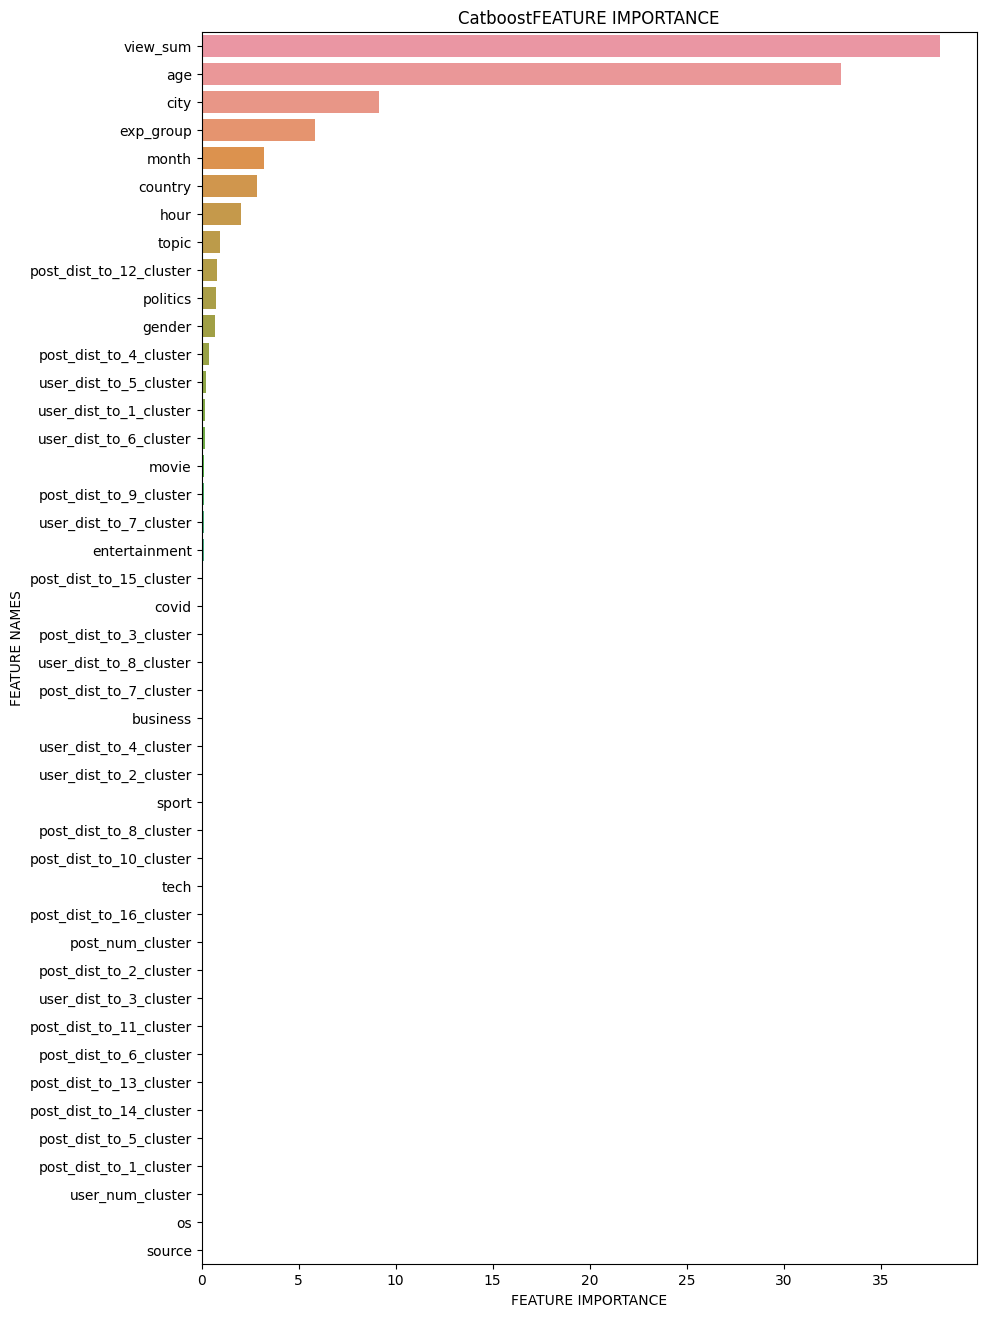

In [100]:
def plot_feature_importance(importance, names, model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(catboost.feature_importances_, X_train.columns, 'Catboost')

In [101]:
# Замерим качества на Кросс-Валидации на 5 фолдах

catboost_cv = cross_validate(catboost, X_train, y_train,
                             scoring="f1",
                             cv=splitter,
                             return_train_score=True)

0:	learn: 0.6650593	total: 390ms	remaining: 3m 14s
1:	learn: 0.6158060	total: 750ms	remaining: 3m 6s
2:	learn: 0.6383477	total: 1.1s	remaining: 3m 2s
3:	learn: 0.6543363	total: 1.43s	remaining: 2m 57s
4:	learn: 0.6769979	total: 1.75s	remaining: 2m 53s
5:	learn: 0.6769068	total: 2.02s	remaining: 2m 46s
6:	learn: 0.6753215	total: 2.29s	remaining: 2m 41s
7:	learn: 0.6821782	total: 2.61s	remaining: 2m 40s
8:	learn: 0.6821753	total: 3s	remaining: 2m 43s
9:	learn: 0.6823719	total: 3.47s	remaining: 2m 50s
10:	learn: 0.6828682	total: 3.91s	remaining: 2m 53s
11:	learn: 0.6820402	total: 4.18s	remaining: 2m 50s
12:	learn: 0.6860573	total: 4.43s	remaining: 2m 46s
13:	learn: 0.6851324	total: 4.69s	remaining: 2m 42s
14:	learn: 0.6867556	total: 4.97s	remaining: 2m 40s
15:	learn: 0.6853528	total: 5.24s	remaining: 2m 38s
16:	learn: 0.6861321	total: 5.52s	remaining: 2m 36s
17:	learn: 0.6857852	total: 5.8s	remaining: 2m 35s
18:	learn: 0.6855873	total: 6.05s	remaining: 2m 33s
19:	learn: 0.6849247	total: 6

In [102]:
print(f"Среднее f1 на тренировочных фолдах: {np.mean(catboost_cv['train_score']).round(3)}")
print(f"Среднее f1 на тестовых фолдах: {np.mean(catboost_cv['test_score']).round(3)}")

Среднее f1 на тренировочных фолдах: 0.29
Среднее f1 на тестовых фолдах: 0.301


## Сохранение и загрузка модели

In [103]:
# Сохраним модель

catboost.save_model(
    "model_test",
    format="cbm"
)

In [104]:
# Проверим что все сохранилось правильно

from_file = CatBoostClassifier()
from_file.load_model("model_test")
from_file.predict(X_test)

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

## Загрузка фичей на сервер

In [105]:
# Загрузим фичи юзеров 

user_data.to_sql(
    'maksim_maltsev_users_lesson_10',
    con = conn_url,
    schema = 'public',
    if_exists = 'replace',
    index = False
)

205

In [106]:
# Загрузим фичи постов 

post_text_df.to_sql(
    'maksim_maltsev_posts_lesson_10',
    con=conn_url,
    schema='public',
    if_exists='replace',
    index = False
)

23

In [54]:
# Функция для батчевой загрузки с сервера

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(conn_url)
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [55]:
# Проверим загрузку фичей юзеров

users_load = batch_load_sql('maksim_maltsev_users_lesson_10')
users_load 

,user_id,gender,age,country,city,exp_group,os,source,business,covid,...,tech,user_dist_to_1_cluster,user_dist_to_2_cluster,user_dist_to_3_cluster,user_dist_to_4_cluster,user_dist_to_5_cluster,user_dist_to_6_cluster,user_dist_to_7_cluster,user_dist_to_8_cluster,user_num_cluster
0,200,1,34,Russia,Degtyarsk,3,Android,ads,28.0,93.0,...,13.0,3.017298,3.578527,2.979593,2.221977,3.635041,3.928811,3.857473,4.662269,3
1,201,0,37,Russia,Abakan,0,Android,ads,29.0,172.0,...,29.0,3.889771,6.056264,6.410042,4.467372,2.955178,3.267942,2.681371,3.399628,6
2,202,1,17,Russia,Smolensk,4,Android,ads,19.0,158.0,...,21.0,3.697253,5.540520,5.193849,3.193716,4.013128,4.113622,1.987895,3.736802,6
3,203,0,18,Russia,Moscow,1,iOS,ads,19.0,71.0,...,9.0,2.231405,2.078781,2.905206,2.956871,4.808711,5.559321,4.258058,5.227635,1
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,8.0,31.0,...,3.0,4.150158,2.145474,2.923159,4.518076,5.788589,7.331909,6.518223,7.071422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic,12.0,83.0,...,12.0,2.236369,2.476267,3.207184,2.973127,3.583664,4.963360,4.091713,4.888445,0
163201,168549,0,18,Russia,Tula,2,Android,organic,14.0,67.0,...,10.0,2.743732,1.837154,2.728837,3.329112,5.176081,6.015830,4.934188,5.767221,1
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic,29.0,85.0,...,14.0,3.264920,3.574120,2.974607,2.543692,3.043625,5.191638,4.237303,4.183708,3
163203,168551,0,38,Russia,Moscow,3,iOS,organic,21.0,122.0,...,15.0,2.247021,3.490732,4.051030,3.041200,2.884440,4.402915,3.253753,4.201481,0


In [56]:
# Проверим загрузку фичей постов

posts_load = batch_load_sql('maksim_maltsev_posts_lesson_10')
posts_load 

,post_id,text,topic,post_dist_to_1_cluster,post_dist_to_2_cluster,post_dist_to_3_cluster,post_dist_to_4_cluster,post_dist_to_5_cluster,post_dist_to_6_cluster,post_dist_to_7_cluster,...,post_dist_to_9_cluster,post_dist_to_10_cluster,post_dist_to_11_cluster,post_dist_to_12_cluster,post_dist_to_13_cluster,post_dist_to_14_cluster,post_dist_to_15_cluster,post_dist_to_16_cluster,post_num_cluster,view_sum
0,1,UK economy facing major risks\n\nThe UK manufa...,business,3.585092,3.664045,3.473402,1.811292,3.371881,2.834850,2.354545,...,3.407721,3.582348,3.387142,2.250781,1.900346,3.465269,3.443681,3.400623,3,8508.0
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,3.282288,3.466703,3.248670,2.184380,3.324140,2.552154,2.317007,...,3.325698,3.416407,3.367440,2.244880,1.427564,3.141119,2.982209,3.204435,12,7495.0
2,3,Asian quake hits European shares\n\nShares in ...,business,3.250408,3.452180,3.397020,1.849820,3.255525,2.884545,2.385220,...,3.358759,3.487534,3.496987,3.063237,1.681745,3.137528,2.972402,3.272925,12,8412.0
3,4,India power shares jump on debut\n\nShares in ...,business,3.818338,3.154751,4.065289,2.459426,3.517417,3.375236,2.811820,...,3.738284,3.687641,3.747411,3.413007,2.434467,3.794705,3.718759,3.682680,12,8158.0
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,2.941870,3.161308,3.239617,1.467498,3.027999,2.134670,2.010762,...,2.803796,3.144227,2.798053,2.950827,2.113957,2.777427,2.638592,2.839679,3,8583.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,2.754806,2.131671,3.396272,3.002734,3.129239,2.329350,2.728915,...,1.276582,3.220133,1.795837,3.364349,3.022051,1.817281,3.052046,2.056374,8,16940.0
7019,7316,I give this movie 2 stars purely because of it...,movie,2.423590,1.948336,3.385172,2.959081,2.930540,2.229762,2.443814,...,0.928871,2.871574,1.450486,3.201939,3.039737,1.840941,3.199964,1.823644,8,6572.0
7020,7317,I cant believe this film was allowed to be mad...,movie,2.177539,2.388481,3.464395,3.194641,2.832132,2.443345,2.801806,...,1.503700,2.743449,2.011372,3.415296,3.270497,1.987747,3.158416,2.219575,8,6803.0
7021,7318,The version I saw of this film was the Blockbu...,movie,3.128242,1.782673,3.411533,3.194560,3.427469,2.309190,2.988913,...,1.487063,3.538512,1.043179,3.452426,3.305676,1.525933,3.218944,1.910421,10,6785.0
